# NLP Deep Learning Model with GRU

## Library

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')

from string import digits
import regex as re
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob, Word
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Import Dataset

In [35]:
df = pd.read_csv("/content/tweets.csv")
df.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


## Statistical Check

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 444.3+ KB


Since target is a categorical numeric variable $int64$, we want to convert it to $str$ for better display of statistics

In [37]:
df.target = df.target.astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        11370 non-null  int64 
 1   keyword   11370 non-null  object
 2   location  7952 non-null   object
 3   text      11370 non-null  object
 4   target    11370 non-null  object
dtypes: int64(1), object(4)
memory usage: 444.3+ KB


In [38]:
df.describe(include = 'object')

,keyword,location,text,target
count,11370,7952,11370,11370
unique,219,4504,11223,2
top,thunderstorm,United States,I want to help you with my project to save the...,0
freq,93,96,3,9256


In [39]:
df.describe(exclude = 'object')

,id
count,11370.000000
mean,5684.500000
std,3282.380615
min,0.000000
25%,2842.250000
50%,5684.500000
75%,8526.750000
max,11369.000000


- Total 11370 data
- Most of the target variable is not talking about disaster
- ID column contain unique values only. We need to drop it
- We want to remove the keyword and location fields too so we can use only the essential features

In [40]:
train = df.drop(['id', 'keyword', 'location'], axis = 1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11370 non-null  object
 1   target  11370 non-null  object
dtypes: object(2)
memory usage: 177.8+ KB


## Duplicated Text

In [41]:
print("Is there any duplicated text? ", train.duplicated(subset = ['text'], keep = False).any())
print("")
print("Total duplicated text = ", train.duplicated(subset = ['text'], keep = False).sum())

Is there any duplicated text?  True

Total duplicated text =  292


We can see that our dataset has a total of 292 duplicate texts. We want to remove those duplicate values for a better dataset

In [42]:
train.drop_duplicates(subset = ['text'], keep = 'last', inplace = True)
train.duplicated(subset = ['text'], keep = False).any()

False

In [43]:
train.tail()

,text,target
11365,Media should have warned us well in advance. T...,0
11366,i feel directly attacked 💀 i consider moonbin ...,0
11367,i feel directly attacked 💀 i consider moonbin ...,0
11368,"ok who remember ""outcast"" nd the ""dora"" au?? T...",0
11369,Jake Corway wrecked while running 14th at IRP.,1


Now let's head into a quick EDA

# EDA

For this EDA, we're using wordcloud to find most frequent word

In [44]:
from wordcloud import WordCloud

texts = " ".join(train.text)

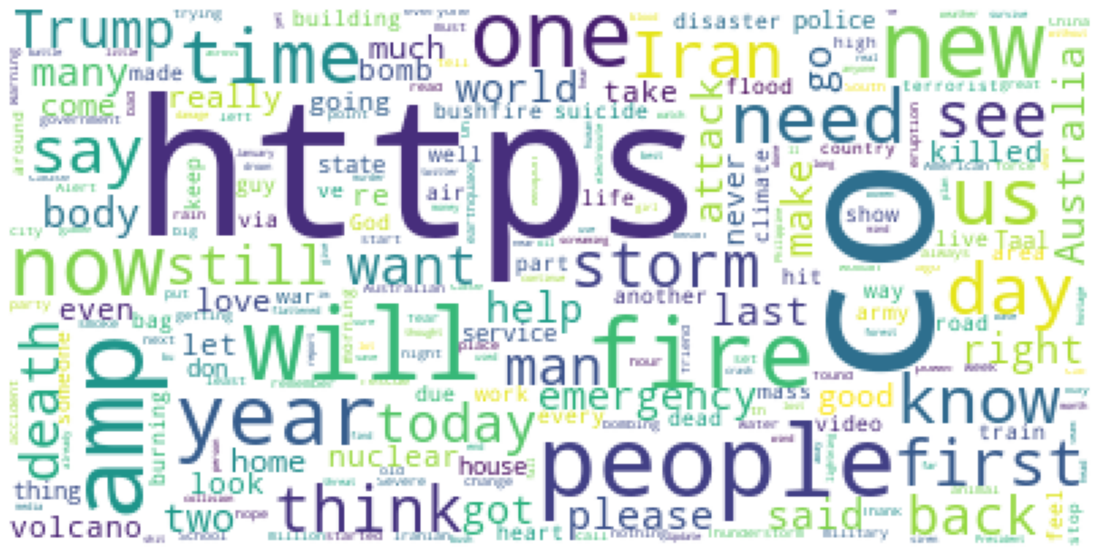

In [45]:
wordclouds = WordCloud(collocations = False, 
                       background_color = 'white',
                      max_font_size = 70,
                      max_words = 250).generate(texts)

plt.rcParams["figure.figsize"] = (20, 10)
plt.imshow(wordclouds)
plt.axis('off')
plt.show()

# Preprocessing

## Lowering

In [46]:
stopword = set(stopwords.words('english'))
lemma = WordNetLemmatizer()
rx = re.compile(r'([^\W\d_])\1{2,}')

def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

def lemmatizing(text):
    pos_tagged = nltk.pos_tag(nltk.word_tokenize(text))
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tagged))
    lemmatized_stc = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_stc.append(word)
        else:       
            lemmatized_stc.append(lemma.lemmatize(word, tag))
    
    return ' '.join(lemmatized_stc)

def clean(text):
    text =  text.lower()
    text_at = text.split()
    text =  ' '.join([i for i in text_at if 'htt' not in i])
    text = text.translate(str.maketrans('', '', digits))
    text = re.sub(r'[^\w]', ' ', text)
    text = ' '.join(word for word in text.split() if word not in stopword)
    text = lemmatizing(text)
    text = re.sub(r'[^\W\d_]+', lambda x: Word(rx.sub(r'\1\1', x.group())).correct() if rx.search(x.group()) else x.group(), text)
    return text

train['clean'] = train.text.apply(lambda x: clean(x))
train.head()

,text,target,clean
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1,communal violence bhainsa telangana stone pelt...
1,Telangana: Section 144 has been imposed in Bha...,1,telangana section impose bhainsa january clash...
2,Arsonist sets cars ablaze at dealership https:...,1,arsonist set car ablaze dealership
3,Arsonist sets cars ablaze at dealership https:...,1,arsonist set car ablaze dealership
4,"""Lord Jesus, your love brings freedom and pard...",0,lord jesus love brings freedom pardon fill hol...


## Counter

In [47]:
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count

counter = counter_word(train.clean)

num_unique_words = len(counter)
num_unique_words

17673

## Tokenizer

In [48]:
ds = {'label':train.target.values, 'text':train.clean.values}
dfs = pd.DataFrame(data = ds)

# Split dataset into training and validation set
train_size = int(dfs.shape[0] * 0.8)

train_df = dfs[:train_size]
val_df = dfs[train_size:]

# split text and labels
train_sentences = train_df.text.to_numpy()
train_labels = train_df.label.to_numpy().astype(int)
val_sentences = val_df.text.to_numpy()
val_labels = val_df.label.to_numpy().astype(int)

In [49]:
# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

In [50]:
# each word has unique index
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)

In [51]:
# Pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
train_padded.shape, val_padded.shape

((8978, 20), (2245, 20))

## Model

In [52]:
tf.keras.backend.clear_session()
np.random.seed(42)

In [53]:
from tensorflow.keras import layers

model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 300, input_length=max_length))
model.add(layers.Bidirectional(
                                tf.keras.layers.GRU(128,
                                return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 300)           5301900   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 256)          330240    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                        

In [54]:
# compile model
lr = 0.000003

model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False),
                optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
                metrics=["accuracy"])

In [55]:
callbacks = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_trained = model.fit(train_padded,
                          train_labels,
                          epochs=30,
                          callbacks=callbacks,
                          validation_data=(val_padded, val_labels))

Epoch 1/30
281/281 [==============================] - 52s 168ms/step - loss: 0.6645 - accuracy: 0.6256 - val_loss: 0.6863 - val_accuracy: 0.6401
Epoch 2/30
281/281 [==============================] - 36s 129ms/step - loss: 0.6435 - accuracy: 0.6817 - val_loss: 0.6660 - val_accuracy: 0.6410
Epoch 3/30
281/281 [==============================] - 36s 128ms/step - loss: 0.6252 - accuracy: 0.7278 - val_loss: 0.6382 - val_accuracy: 0.6588
Epoch 4/30
281/281 [==============================] - 36s 129ms/step - loss: 0.6081 - accuracy: 0.7651 - val_loss: 0.6238 - val_accuracy: 0.6815
Epoch 5/30
281/281 [==============================] - 37s 131ms/step - loss: 0.5911 - accuracy: 0.7997 - val_loss: 0.6127 - val_accuracy: 0.6971
Epoch 6/30
281/281 [==============================] - 35s 126ms/step - loss: 0.5749 - accuracy: 0.8237 - val_loss: 0.6018 - val_accuracy: 0.7145
Epoch 7/30
281/281 [==============================] - 36s 126ms/step - loss: 0.5589 - accuracy: 0.8411 - val_loss: 0.5926 - val_ac

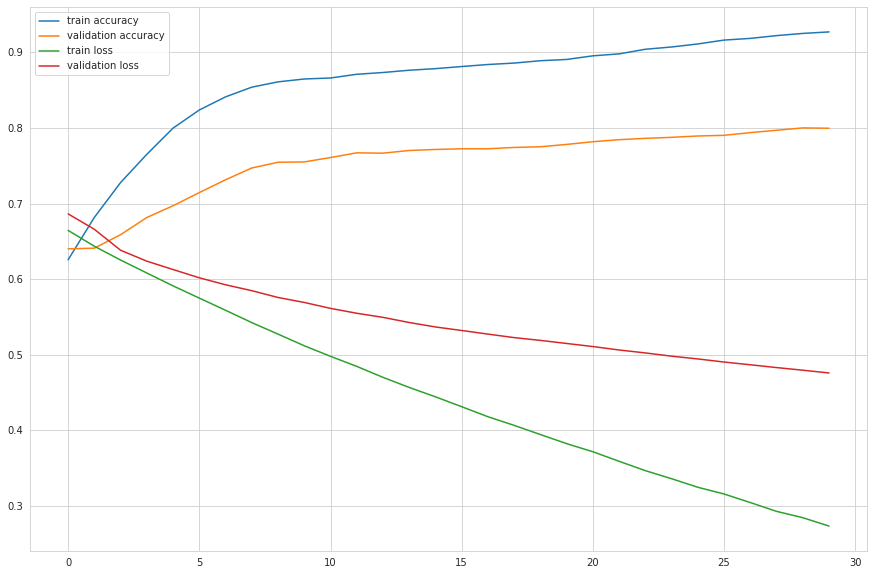

In [56]:
plt.figure(figsize=(15, 10))
plt.plot(model_trained.history["accuracy"], label="train accuracy")
plt.plot(model_trained.history["val_accuracy"], label="validation accuracy")
plt.plot(model_trained.history["loss"], label="train loss")
plt.plot(model_trained.history["val_loss"], label="validation loss")

plt.legend()

In [57]:
model.evaluate(val_padded, val_labels)

71/71 [==============================] - 1s 16ms/step - loss: 0.4760 - accuracy: 0.7996


[0.4759645462036133, 0.7995545864105225]